# Phase 4: Conduct image classification using Convolutional Neural Network approach

# Experiment 1: Constructing Base Convolutional Neural Network for image classification, few data augmentation techniques, calculating classification report, plotting confusion matrix and loss/learning curve.

**Step 1: Importing all necessary libraries. Will add as per requirement**

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

**Step 2: Paths to dataset(which was already prepared in phase 1) and labels from class_name.txt**

In [4]:
base_dir = "prepared_dataset2"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
class_labels_path = os.path.join("TinyImageNet100", "class_name.txt")

# Parameters
num_classes = 15
img_height, img_width = 64, 64
batch_size = 64  # batch size for stability
epochs = 30
learning_rate = 0.001
validation_split = 0.2  # Proportion of training set to use as validation

**Step 3: Loading class labels and lables of selected classes**

In [7]:
# Cell 3: Load class labels
def load_class_labels(class_labels_path, selected_classes):
    class_labels = {}
    with open(class_labels_path, "r") as f:
        for line in f:
            class_name, *labels = line.strip().split()
            if class_name in selected_classes:
                class_labels[class_name] = " ".join(labels)
    return [class_labels[class_name] for class_name in selected_classes]

# Get selected class names from dataset folders
selected_classes = sorted(os.listdir(train_dir))
class_labels = load_class_labels(class_labels_path, selected_classes)

**Step 4: Function to prepare data loaders and data augmentation techniques to improve generalization of model**

In [9]:

def get_data_loaders(train_dir, test_dir, batch_size, validation_split):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)), # Data augmentation Techniques to improve the generalization of model
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Step 5: Constructing Convolutiona Neural Network naming HCNN with ..... layers**

In [11]:
# HCNN Model...self constructed model
class HCNN(nn.Module):
    def __init__(self, num_classes):
        super(HCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_height // 8) * (img_width // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # dropout rate for better learning
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

**Step 6: Prepare data loaders, initilaizing model,loss function and optimizer(SGD)**

In [13]:
train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

# Initialize model, loss function, and optimizer
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS for MacBook Pro with Apple Silicon
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # momentum for smoother updates


**Step 7: Training Model**

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

**Step 8: Function to plot curves and test model**

In [17]:
def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 8))
    
    # Loss curve
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy curve
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
# Function to compute and display final test accuracy and classification report
def test_model(model, test_loader, criterion, device, class_labels):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct / total
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.2f}%")

    # Print classification report
    print("\nClassification Report:")
    #print(classification_report(all_labels, all_preds, target_names=class_labels))
    print(classification_report(all_labels, all_preds, target_names=class_labels, zero_division=0))
    # Plot confusion matrix
    #print("\nConfusion Matrix:")
    #plot_confusion_matrix(all_labels, all_preds, class_labels,device)

    return test_acc


**Step 9: Function to plot confusion matrix**

In [19]:

def plot_confusion_matrix(model, test_loader, class_labels, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


**Step 10: Train,Evaluate and Saving the Model**

Epoch 1/30, Train Loss: 2.3430, Train Accuracy: 25.31%, Validation Loss: 1.9070, Validation Accuracy: 41.75%
Epoch 2/30, Train Loss: 1.8259, Train Accuracy: 42.02%, Validation Loss: 1.6090, Validation Accuracy: 49.58%
Epoch 3/30, Train Loss: 1.5897, Train Accuracy: 48.88%, Validation Loss: 1.4665, Validation Accuracy: 54.00%
Epoch 4/30, Train Loss: 1.4107, Train Accuracy: 55.35%, Validation Loss: 1.4947, Validation Accuracy: 52.17%
Epoch 5/30, Train Loss: 1.2986, Train Accuracy: 58.73%, Validation Loss: 1.3589, Validation Accuracy: 55.83%
Epoch 6/30, Train Loss: 1.1972, Train Accuracy: 61.33%, Validation Loss: 1.3507, Validation Accuracy: 57.42%
Epoch 7/30, Train Loss: 1.0938, Train Accuracy: 65.48%, Validation Loss: 1.2403, Validation Accuracy: 59.42%
Epoch 8/30, Train Loss: 1.0038, Train Accuracy: 68.69%, Validation Loss: 1.2130, Validation Accuracy: 61.42%
Epoch 9/30, Train Loss: 0.9192, Train Accuracy: 70.50%, Validation Loss: 1.2020, Validation Accuracy: 61.50%
Epoch 10/30, Train 

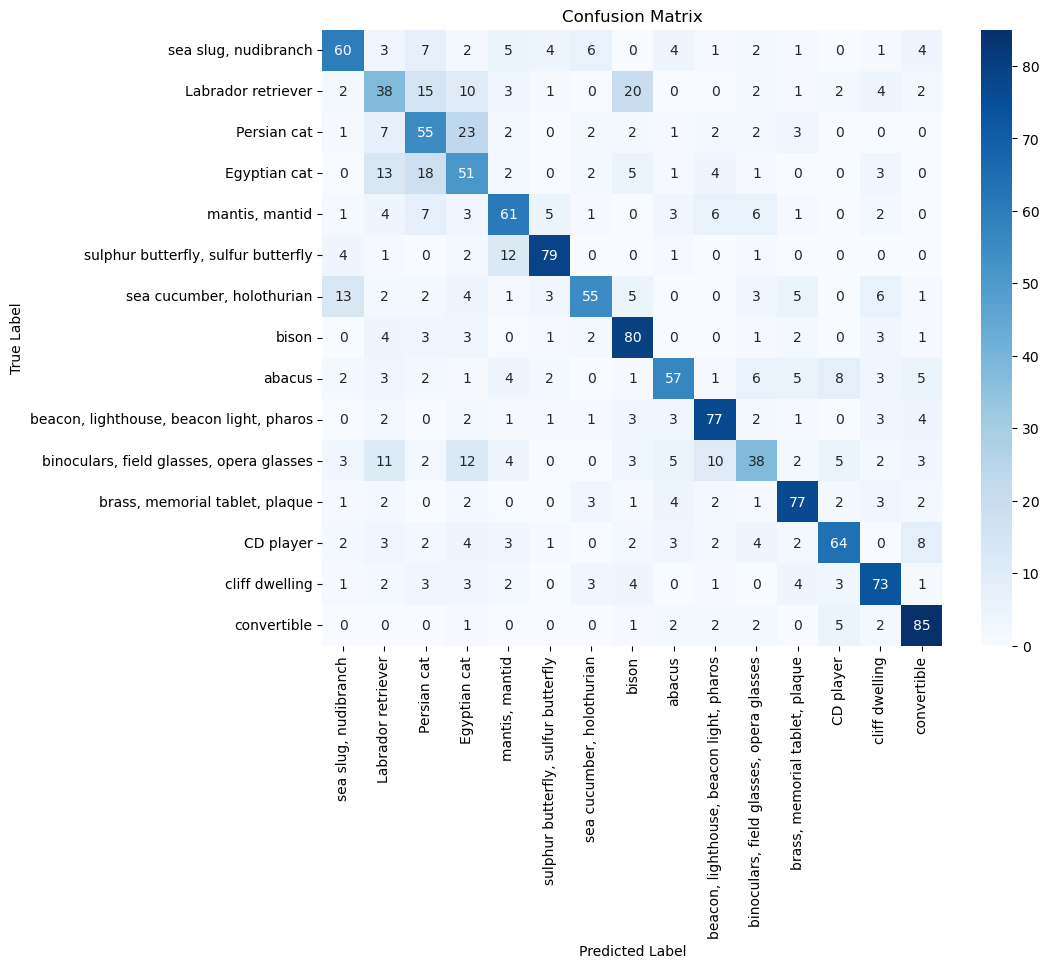

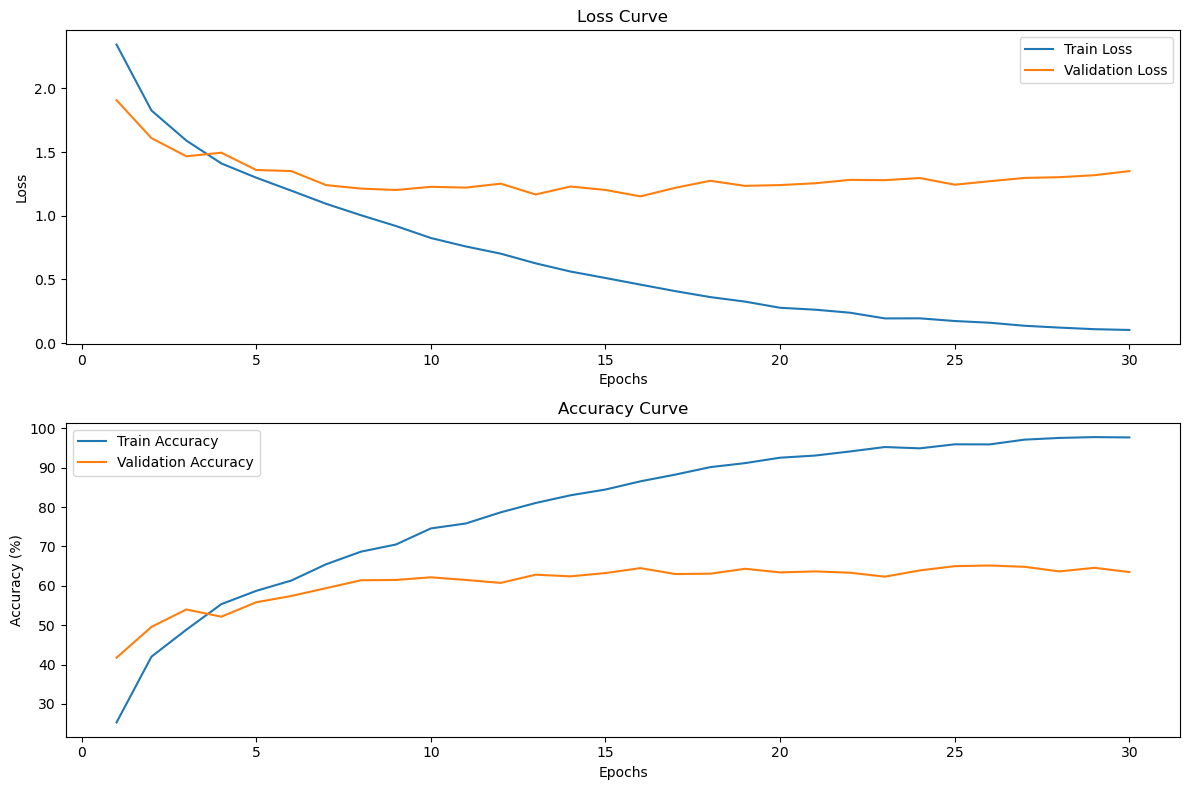

Model saved as HCNN_model.pth


In [21]:
# Train and Evaluate
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)
test_acc = test_model(model, test_loader, criterion, device, class_labels)
plot_confusion_matrix(model, test_loader, class_labels, device)
plot_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Cell 9: Save Model
torch.save(model.state_dict(), "HCNN_model.pth")
print("Model saved as HCNN_model.pth")


# Experiment 2: All hyperparameters are same but more rigourous data augmentation to prevent over fitting and dropout rate=0.3 for better learning

Epoch 1/30, Train Loss: 2.3939, Train Accuracy: 22.90%, Validation Loss: 2.1402, Validation Accuracy: 32.17%
Epoch 2/30, Train Loss: 2.0214, Train Accuracy: 35.12%, Validation Loss: 1.9178, Validation Accuracy: 39.33%
Epoch 3/30, Train Loss: 1.8095, Train Accuracy: 40.94%, Validation Loss: 1.8446, Validation Accuracy: 39.92%
Epoch 4/30, Train Loss: 1.7092, Train Accuracy: 44.65%, Validation Loss: 1.6783, Validation Accuracy: 47.42%
Epoch 5/30, Train Loss: 1.6120, Train Accuracy: 48.33%, Validation Loss: 1.6697, Validation Accuracy: 47.58%
Epoch 6/30, Train Loss: 1.5373, Train Accuracy: 50.33%, Validation Loss: 1.5733, Validation Accuracy: 49.17%
Epoch 7/30, Train Loss: 1.4982, Train Accuracy: 52.00%, Validation Loss: 1.5467, Validation Accuracy: 50.42%
Epoch 8/30, Train Loss: 1.4147, Train Accuracy: 54.29%, Validation Loss: 1.5598, Validation Accuracy: 50.17%
Epoch 9/30, Train Loss: 1.3784, Train Accuracy: 55.52%, Validation Loss: 1.5422, Validation Accuracy: 50.33%
Epoch 10/30, Train 

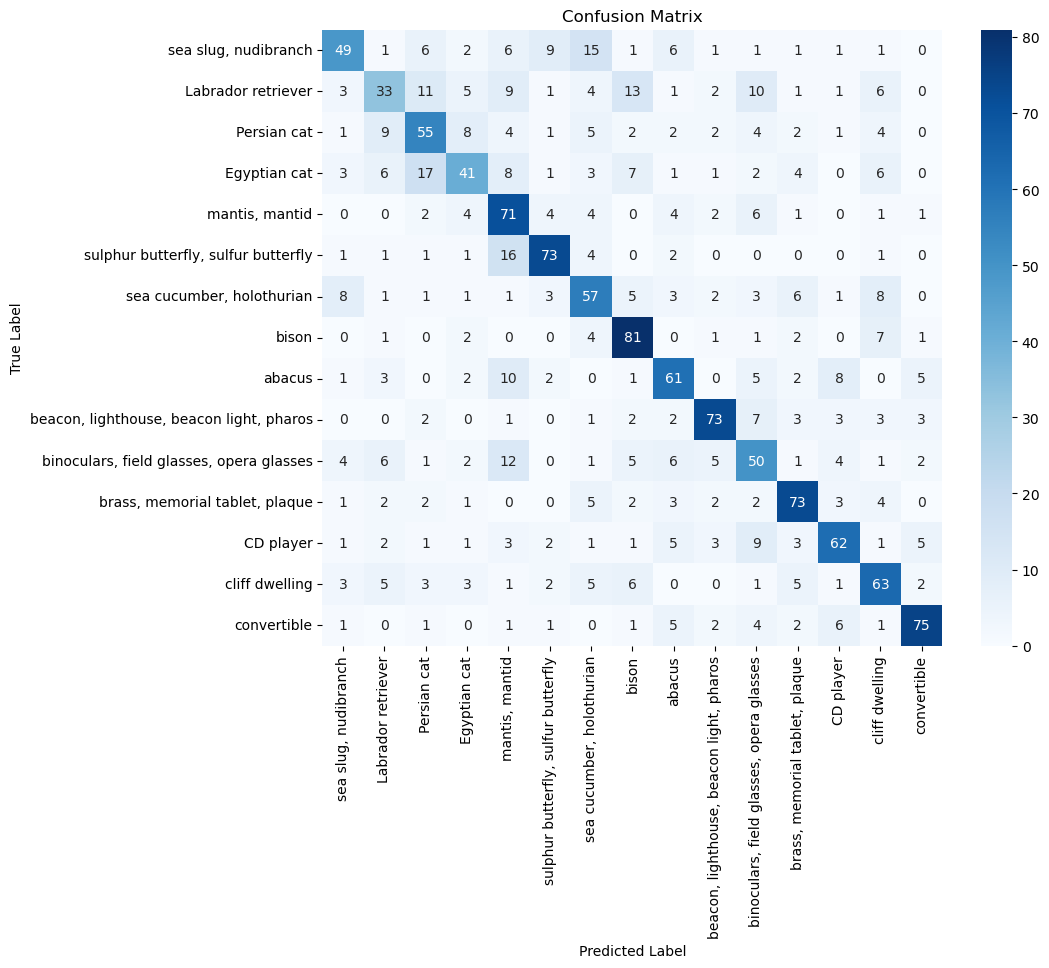

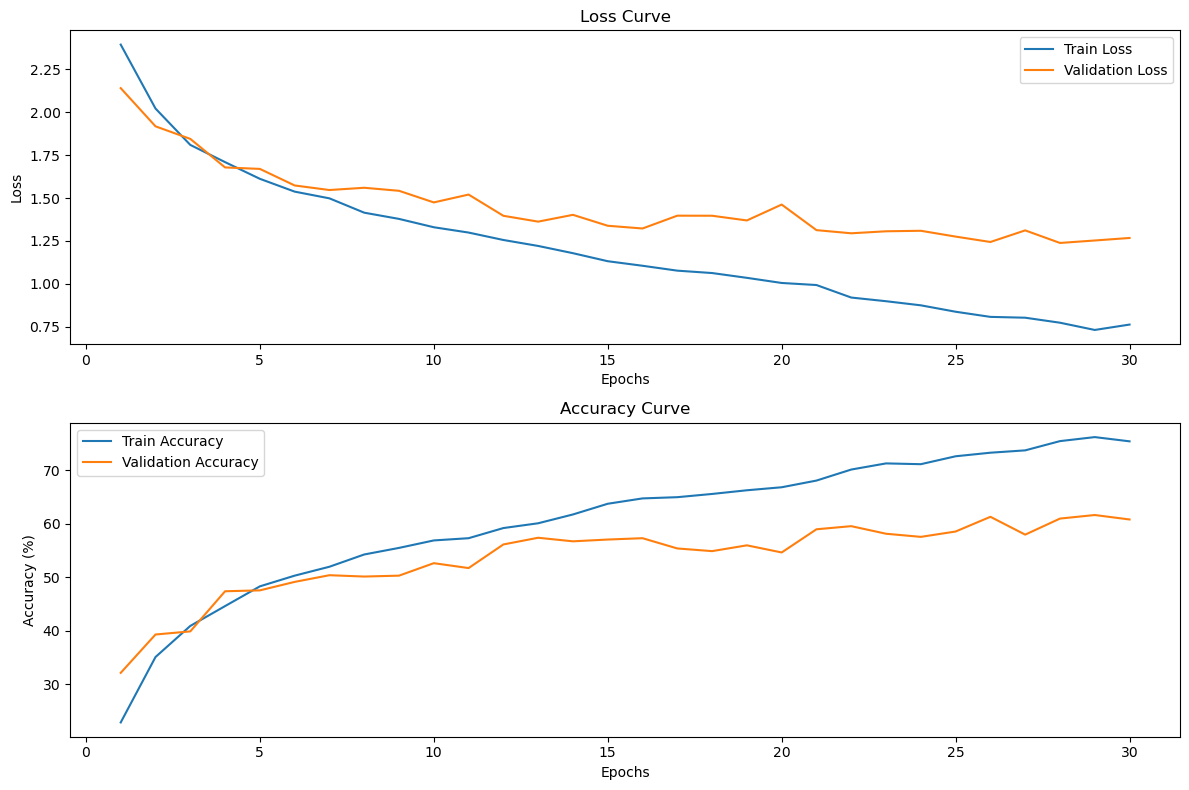

Model saved as HinaCNNSecondExpDA.pth


In [23]:
# Parameters
num_classes = 15
img_height, img_width = 64, 64
batch_size = 64  # batch size for stability
epochs = 30
learning_rate = 0.001
validation_split = 0.2  # Proportion of training set to use as validation

# Data loader function
def get_data_loaders(train_dir, test_dir, batch_size, validation_split):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # added
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #added
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    # Split train dataset into training and validation datasets
    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Define HinaCNNSecondExp Model
class HinaCNNSecondExpDA(nn.Module):
    def __init__(self, num_classes):
        super(HinaCNNSecondExpDA, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_height // 8) * (img_width // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # dropout rate for better learning
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

# Initialize model, loss function, and optimizer
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS for MacBook Pro with Apple Silicon
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HinaCNNSecondExpDA(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # momentum for smoother updates

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 8))
    
    # Loss curve
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy curve
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# Function to compute and display final test accuracy and classification report
def test_model(model, test_loader, criterion, device, class_labels):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct / total
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.2f}%")

    # Print classification report
    print("\nClassification Report:")
    #print(classification_report(all_labels, all_preds, target_names=class_labels))
    print(classification_report(all_labels, all_preds, target_names=class_labels, zero_division=0))
    # Plot confusion matrix
    #print("\nConfusion Matrix:")
    #plot_confusion_matrix(all_labels, all_preds, class_labels,device)

    return test_acc


def plot_confusion_matrix(model, test_loader, class_labels, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Training and Evaluate
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)
test_acc = test_model(model, test_loader, criterion, device, class_labels)
plot_confusion_matrix(model, test_loader, class_labels, device)
plot_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Saving the Model
torch.save(model.state_dict(), "HinaCNNSecondExpDA.pth")
print("Model saved as HinaCNNSecondExpDA.pth")

# Experiment 3: Learning rate: 0.0001, drop out:0.3, epochs:50

Epoch 1/50, Train Loss: 2.6582, Train Accuracy: 11.79%, Validation Loss: 2.5362, Validation Accuracy: 17.42%
Epoch 2/50, Train Loss: 2.4646, Train Accuracy: 21.60%, Validation Loss: 2.3868, Validation Accuracy: 22.67%
Epoch 3/50, Train Loss: 2.3360, Train Accuracy: 25.19%, Validation Loss: 2.2909, Validation Accuracy: 26.33%
Epoch 4/50, Train Loss: 2.2494, Train Accuracy: 29.04%, Validation Loss: 2.2072, Validation Accuracy: 29.67%
Epoch 5/50, Train Loss: 2.1902, Train Accuracy: 30.23%, Validation Loss: 2.1504, Validation Accuracy: 31.50%
Epoch 6/50, Train Loss: 2.1335, Train Accuracy: 32.56%, Validation Loss: 2.1141, Validation Accuracy: 32.00%
Epoch 7/50, Train Loss: 2.0907, Train Accuracy: 33.98%, Validation Loss: 2.0941, Validation Accuracy: 33.58%
Epoch 8/50, Train Loss: 2.0462, Train Accuracy: 35.06%, Validation Loss: 2.0550, Validation Accuracy: 33.50%
Epoch 9/50, Train Loss: 2.0161, Train Accuracy: 35.88%, Validation Loss: 2.0146, Validation Accuracy: 35.83%
Epoch 10/50, Train 

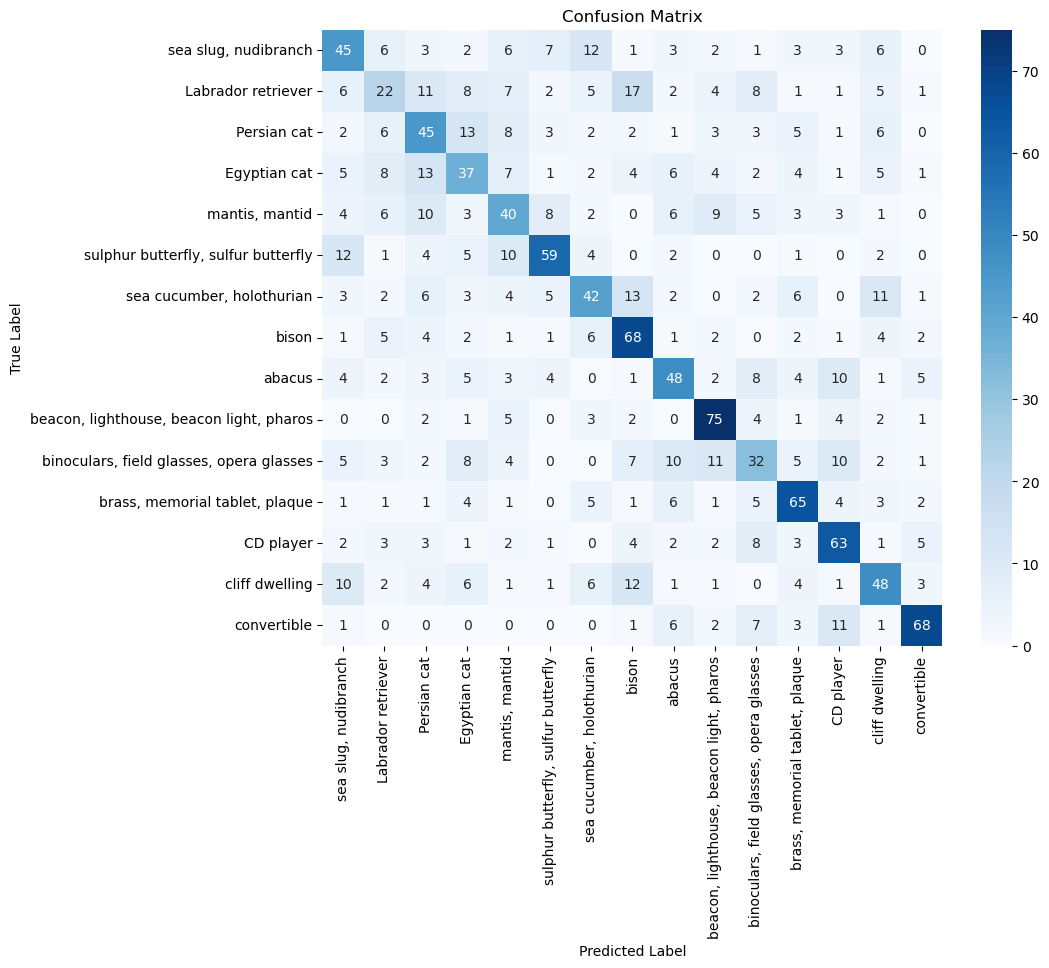

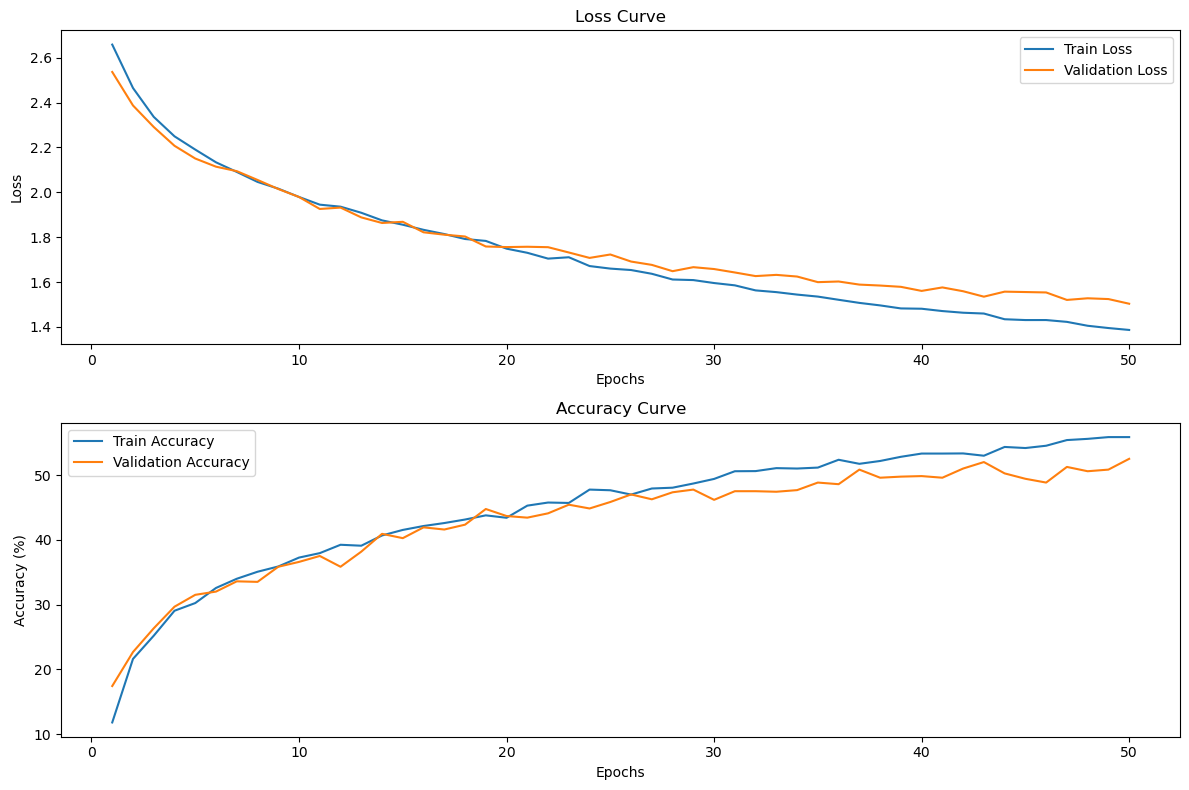

Model saved as HinaCNNThirdExp.pth


In [25]:
# Parameters
num_classes = 15
img_height, img_width = 64, 64
batch_size = 64  # batch size for stability
epochs = 50
learning_rate = 0.0001
validation_split = 0.2  # Proportion of training set to use as validation

# Data loader function
def get_data_loaders(train_dir, test_dir, batch_size, validation_split):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # added
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), #added
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    # Split train dataset into training and validation datasets
    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Define HinaCNNThirdExp Model
class HinaCNNThirdExp(nn.Module):
    def __init__(self, num_classes):
        super(HinaCNNThirdExp, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_height // 8) * (img_width // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # dropout rate for better learning
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

# Initialize model, loss function, and optimizer
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS for MacBook Pro with Apple Silicon
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HinaCNNThirdExp(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # momentum for smoother updates

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 8))
    
    # Loss curve
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy curve
    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
# Function to compute and display final test accuracy and classification report
def test_model(model, test_loader, criterion, device, class_labels):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct / total
    print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.2f}%")

    # Print classification report
    print("\nClassification Report:")
    #print(classification_report(all_labels, all_preds, target_names=class_labels))
    print(classification_report(all_labels, all_preds, target_names=class_labels, zero_division=0))
    # Plot confusion matrix
    #print("\nConfusion Matrix:")
    #plot_confusion_matrix(all_labels, all_preds, class_labels,device)

    return test_acc


def plot_confusion_matrix(model, test_loader, class_labels, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Training and Evaluate
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)
test_acc = test_model(model, test_loader, criterion, device, class_labels)
plot_confusion_matrix(model, test_loader, class_labels, device)
plot_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Saving the Model
torch.save(model.state_dict(), "HinaCNNThirdExp.pth")
print("Model saved as HinaCNNThirdExp.pth")

# Experiment 4: Hyperparameter tunning by Grid search. It will find the best hyperparameters for model without changing number of layers


Running experiment with: LR=0.01, Batch Size=32, Dropout=0.3
Epoch 1/50, Train Loss: 2.5037, Train Accuracy: 21.35%, Validation Loss: 2.4183, Validation Accuracy: 25.83%
Epoch 2/50, Train Loss: 2.3048, Train Accuracy: 26.46%, Validation Loss: 2.2408, Validation Accuracy: 29.17%
Epoch 3/50, Train Loss: 2.2853, Train Accuracy: 28.40%, Validation Loss: 2.2121, Validation Accuracy: 29.75%
Epoch 4/50, Train Loss: 2.1956, Train Accuracy: 30.94%, Validation Loss: 2.1746, Validation Accuracy: 31.58%
Epoch 5/50, Train Loss: 2.0926, Train Accuracy: 33.75%, Validation Loss: 2.0214, Validation Accuracy: 38.33%
Epoch 6/50, Train Loss: 1.9991, Train Accuracy: 37.44%, Validation Loss: 1.9415, Validation Accuracy: 39.50%
Epoch 7/50, Train Loss: 1.9837, Train Accuracy: 37.71%, Validation Loss: 1.9114, Validation Accuracy: 38.83%
Epoch 8/50, Train Loss: 1.9089, Train Accuracy: 40.46%, Validation Loss: 1.8850, Validation Accuracy: 43.75%
Epoch 9/50, Train Loss: 1.8116, Train Accuracy: 43.67%, Validation

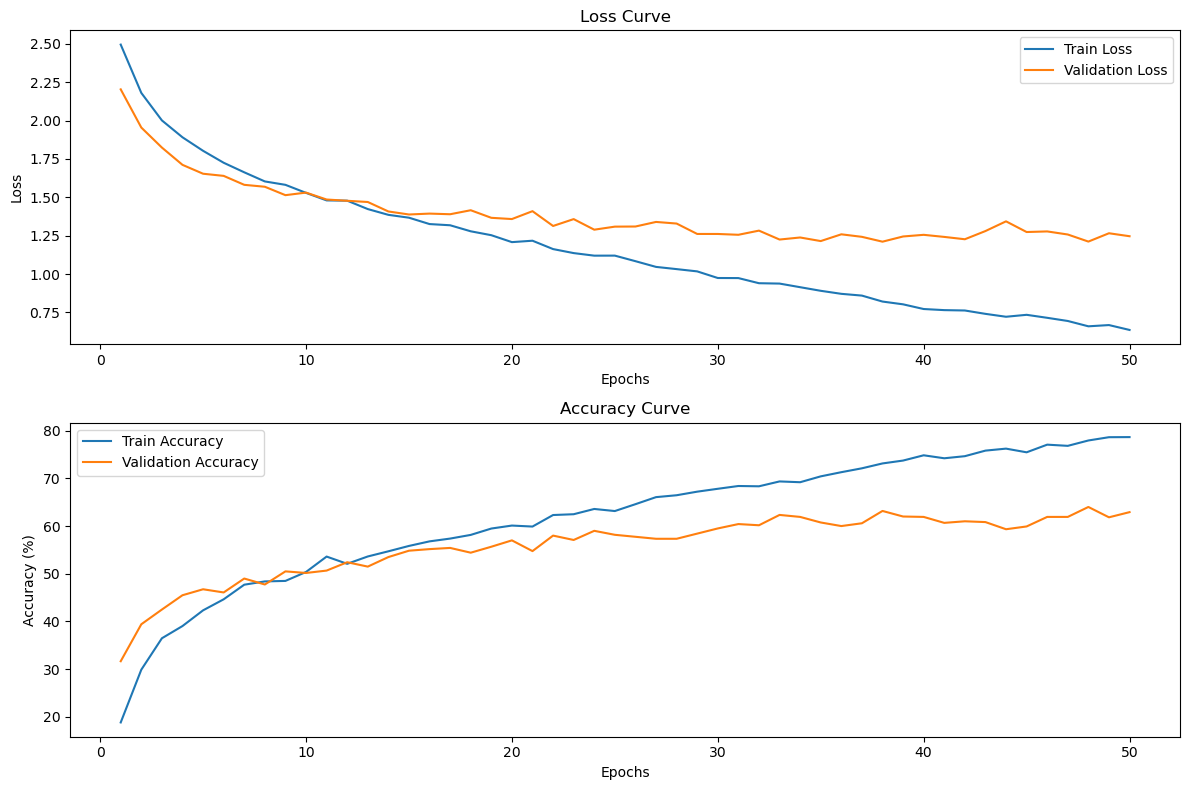

In [27]:
from itertools import product

# Function to run experiments with different hyperparameters
def run_experiment(learning_rate, batch_size, dropout_rate):
    print(f"\nRunning experiment with: LR={learning_rate}, Batch Size={batch_size}, Dropout={dropout_rate}")

    # Update data loaders with new batch size
    train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

    # Define the model with updated dropout rate
    class GridSearchCNN(HinaCNNSecondExpDA):
        def __init__(self, num_classes, dropout_rate):
            super(GridSearchCNN, self).__init__(num_classes)
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(128 * (img_height // 8) * (img_width // 8), 256),
                nn.ReLU(),
                nn.Dropout(dropout_rate),  # Update dropout rate
                nn.Linear(256, num_classes)
            )

    model = GridSearchCNN(num_classes, dropout_rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Train and validate the model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, epochs
    )
    
    # Get final validation accuracy
    final_val_acc = val_accuracies[-1]
    
    # Test the model
    test_acc = test_model(model, test_loader, criterion, device, class_labels)

    return final_val_acc, test_acc, train_losses, train_accuracies, val_losses, val_accuracies

# Define hyperparameter search space
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64, 128]
dropout_rates = [0.3, 0.5]

# Perform grid search
best_hyperparams = None
best_val_acc = 0
results = []

for lr, bs, dr in product(learning_rates, batch_sizes, dropout_rates):
    val_acc, test_acc, train_losses, train_accuracies, val_losses, val_accuracies = run_experiment(
        learning_rate=lr, batch_size=bs, dropout_rate=dr
    )
    results.append((lr, bs, dr, val_acc, test_acc))
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hyperparams = (lr, bs, dr)
        best_train_losses, best_train_accuracies = train_losses, train_accuracies
        best_val_losses, best_val_accuracies = val_losses, val_accuracies
        
         # Save the current best model
        #torch.save(model.state_dict(), "bestHCNN_model.pth")
       # print(f"Best model saved with Validation Accuracy: {val_acc:.2f}%")

# Print the best hyperparameters
print(f"\nBest Hyperparameters: LR={best_hyperparams[0]}, Batch Size={best_hyperparams[1]}, Dropout={best_hyperparams[2]}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
# Save the current best model
torch.save(model.state_dict(), "BestGridSearchCNN.pth")
print(f"Best model saved with Validation Accuracy: {best_val_acc:.2f}%")

# Log all results
print("\nAll Results:")
for lr, bs, dr, val_acc, test_acc in results:
    print(f"LR={lr}, Batch Size={bs}, Dropout={dr}, Val Acc={val_acc:.2f}%, Test Acc={test_acc:.2f}%")

# Plot the best curves
print("\nVisualizing the Best Model Performance:")
plot_curves(best_train_losses, best_train_accuracies, best_val_losses, best_val_accuracies)


# Experiment 5: Fine Tuning....increased epochs, added more augmentation techniques, L2 regularization

/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/70, Train Loss: 2.5240, Train Acc: 17.42%, Val Loss: 2.2855, Val Acc: 26.92%
Epoch 2/70, Train Loss: 2.3286, Train Acc: 24.62%, Val Loss: 2.1842, Val Acc: 28.75%
Epoch 3/70, Train Loss: 2.2345, Train Acc: 28.00%, Val Loss: 2.1348, Val Acc: 30.25%
Epoch 4/70, Train Loss: 2.1985, Train Acc: 28.98%, Val Loss: 2.0775, Val Acc: 32.92%
Epoch 5/70, Train Loss: 2.1347, Train Acc: 31.15%, Val Loss: 2.0862, Val Acc: 32.17%
Epoch 6/70, Train Loss: 2.0943, Train Acc: 32.10%, Val Loss: 1.9002, Val Acc: 38.75%
Epoch 7/70, Train Loss: 2.0629, Train Acc: 34.62%, Val Loss: 1.9369, Val Acc: 38.58%
Epoch 8/70, Train Loss: 1.9993, Train Acc: 34.90%, Val Loss: 2.0395, Val Acc: 34.17%
Epoch 9/70, Train Loss: 1.9581, Train Acc: 35.96%, Val Loss: 1.8758, Val Acc: 38.50%
Epoch 10/70, Train Loss: 1.9182, Train Acc: 38.10%, Val Loss: 1.8728, Val Acc: 39.42%
Epoch 11/70, Train Loss: 1.8975, Train Acc: 39.25%, Val Loss: 1.8658, Val Acc: 39.50%
Epoch 12/70, Train Loss: 1.8712, Train Acc: 39.31%, Val Loss: 1

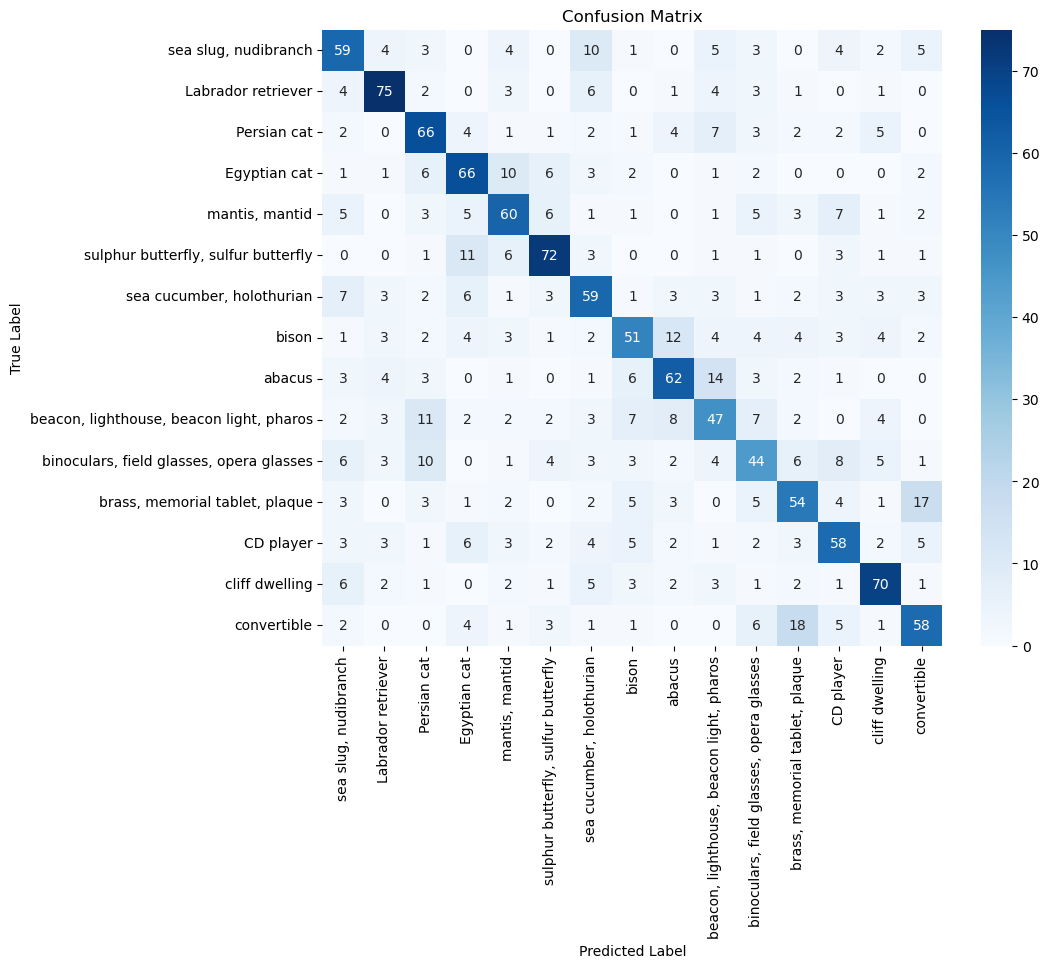

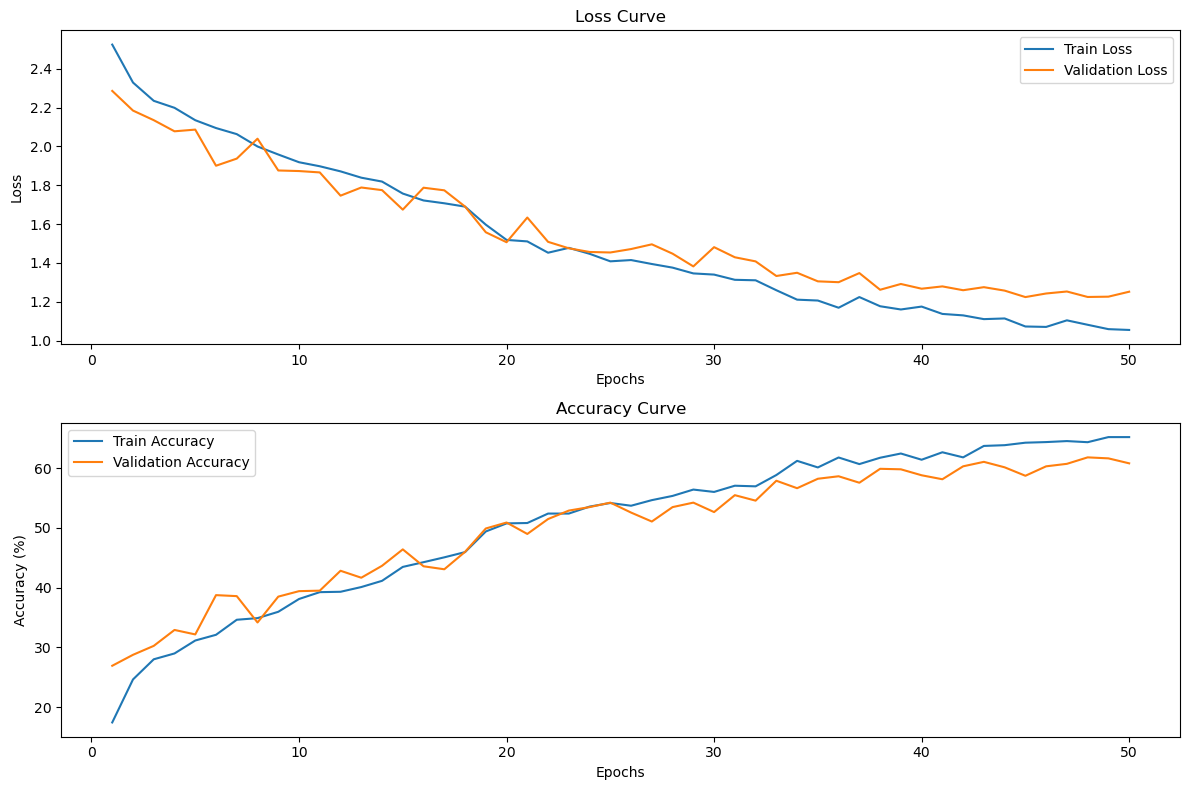

Model saved as HinaCNNFineTunned_Model.pth


In [33]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Paths Fine Tuning
base_dir = "prepared_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Parameters (Updated)
num_classes = 15
img_height, img_width = 64, 64
batch_size = 32  # Same as per grid search
epochs = 70  # increased from grid search to observe results
learning_rate = 0.001  # Same as per grid search
validation_split = 0.2  
weight_decay = 0.00005  # **L2 Regularization**

# **Updated Data Augmentation**
def get_data_loaders(train_dir, test_dir, batch_size, validation_split):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),  # **Lowered from 30 → 20**
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
        transforms.ToTensor(),  # **Ensure image is converted to tensor first**
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))  # **Reduced probability & smaller scale**
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    # Split train dataset into training and validation datasets
    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Define CNN Model
class HinaCNNFineTunned_Model(nn.Module):
    def __init__(self, num_classes=15):
        super(HinaCNNFineTunned_Model, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_height // 8) * (img_width // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # **Reduced Dropout from 0.6 → 0.5**
            nn.Linear(256, num_classes)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

# Initialize model, loss function, optimizer, and scheduler
if torch.backends.mps.is_available():
    device = torch.device("mps")  
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model =HinaCNNFineTunned_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# **L2 Regularization Updated**
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95, weight_decay=weight_decay)

# **Learning Rate Scheduler Tweaked**
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# **Early Stopping Parameters**
early_stopping_patience = 5  
best_val_loss = float("inf")
patience_counter = 0

# Training function with early stopping and scheduler
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # **Early Stopping**
        global best_val_loss, patience_counter
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  
        else:
            patience_counter += 1  
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered. Stopping training.")
                break  

        # **Step the Scheduler**
        scheduler.step(val_loss)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs
)

# Test the model
test_acc = test_model(model, test_loader, criterion, device, class_labels)
plot_confusion_matrix(model, test_loader, class_labels, device)
plot_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Saving the Model
torch.save(model.state_dict(), "HinaCNNFineTunned_Model.pth")
print("Model saved as HinaCNNFineTunned_Model.pth")


# Experiment 6: 
**Learning Rate = 0.001
Batch Size = 32
Epochs = 30
Dropout = 0.5
Added Learning Rate Scheduler (Reduces LR if validation loss plateaus)
Added Early Stopping (Stops training when no improvement)
Added L2 Regularization (Weight decay in the optimizer)
CNN layers added to capture more complex patternsw**

/Users/hinaghazanfar/Documents/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Train Loss: 2.4299, Train Acc: 20.38%, Val Loss: 2.1759, Val Acc: 30.17%
Epoch 2/30, Train Loss: 2.1379, Train Acc: 30.58%, Val Loss: 1.9779, Val Acc: 37.08%
Epoch 3/30, Train Loss: 1.9694, Train Acc: 35.88%, Val Loss: 1.8768, Val Acc: 38.42%
Epoch 4/30, Train Loss: 1.8737, Train Acc: 38.33%, Val Loss: 1.8151, Val Acc: 40.75%
Epoch 5/30, Train Loss: 1.8038, Train Acc: 40.42%, Val Loss: 1.7494, Val Acc: 43.83%
Epoch 6/30, Train Loss: 1.6934, Train Acc: 45.19%, Val Loss: 1.7368, Val Acc: 45.25%
Epoch 7/30, Train Loss: 1.6318, Train Acc: 46.77%, Val Loss: 1.6950, Val Acc: 45.42%
Epoch 8/30, Train Loss: 1.5567, Train Acc: 48.69%, Val Loss: 1.6646, Val Acc: 45.58%
Epoch 9/30, Train Loss: 1.5072, Train Acc: 50.54%, Val Loss: 1.5923, Val Acc: 50.50%
Epoch 10/30, Train Loss: 1.4277, Train Acc: 53.52%, Val Loss: 1.6655, Val Acc: 48.50%
Epoch 11/30, Train Loss: 1.3812, Train Acc: 54.81%, Val Loss: 1.5152, Val Acc: 52.83%
Epoch 12/30, Train Loss: 1.3562, Train Acc: 56.35%, Val Loss: 1

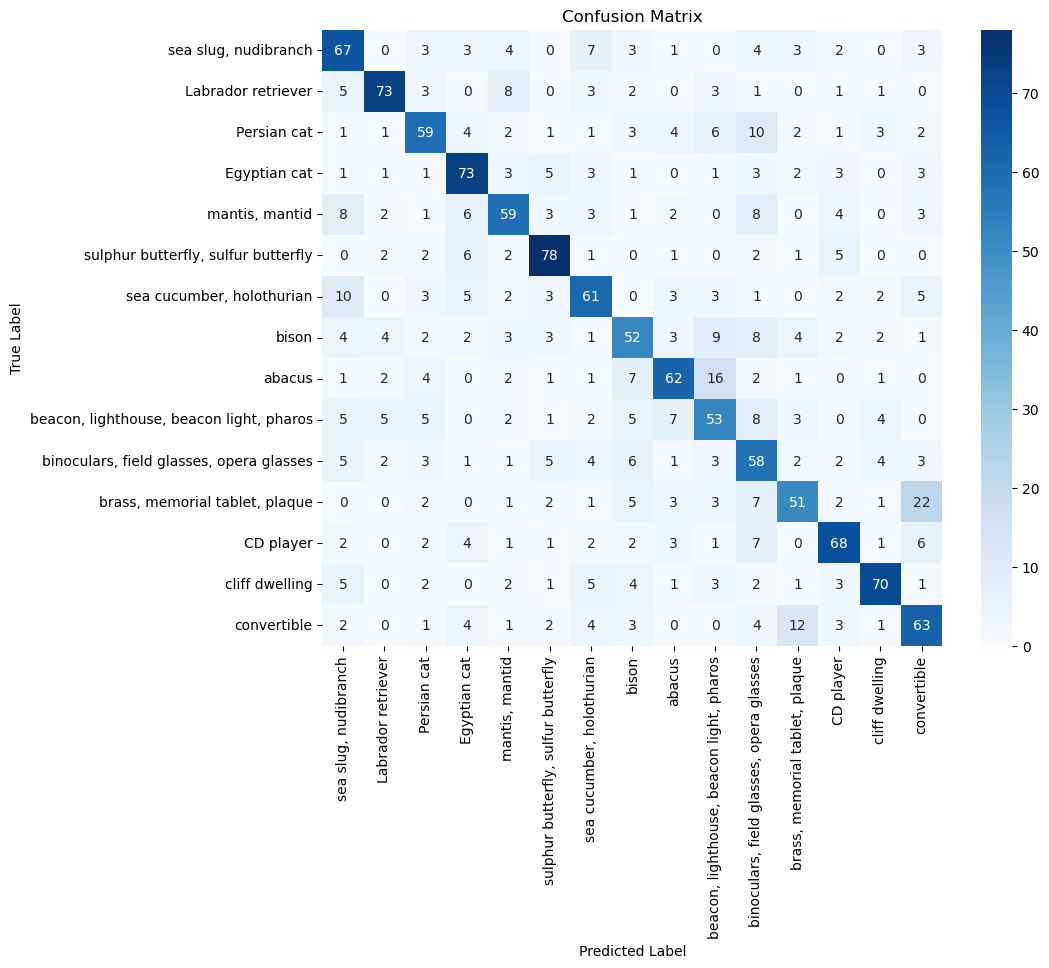

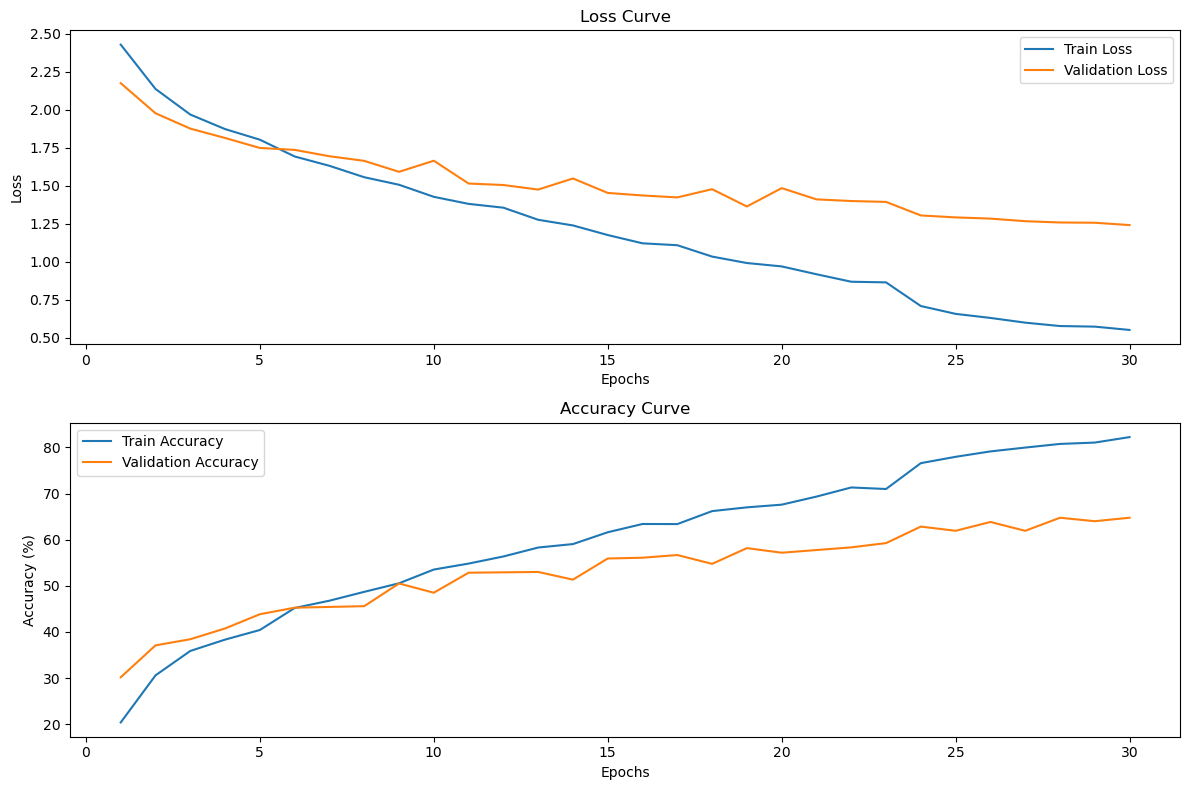

Model saved as HinaCNNLayers_Model.pth


In [35]:
base_dir = "prepared_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
class_labels_path = os.path.join("TinyImageNet100", "class_name.txt")
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Parameters (Updated)
num_classes = 15
img_height, img_width = 64, 64
batch_size = 32 # remained same as per gridsearch
epochs = 30 # remained same as per gridsearch
learning_rate = 0.001  # remained same as per gridsearch
validation_split = 0.2  
weight_decay = 0.0001  # L2 Regularization (Added)

# Data loader function
def get_data_loaders(train_dir, test_dir, batch_size, validation_split):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)

    # Split train dataset into training and validation datasets
    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Define CNN Model (Dropout changed to 0.5)
class HinaCNNLayers_Model(nn.Module):
    def __init__(self, num_classes=15):
        super(HinaCNNLayers_Model, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # New layers added to capture more complex patterns
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),  
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased to 0.5
            nn.Linear(512, num_classes)  
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

train_loader, val_loader, test_loader = get_data_loaders(train_dir, test_dir, batch_size, validation_split)

# Initialize model, loss function, optimizer, and scheduler
if torch.backends.mps.is_available():
    device = torch.device("mps")  
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model =HinaCNNLayers_Model(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

# Mainadditions here to check their impact

# **L2 Regularization Added (weight_decay=0.0001)**
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95, weight_decay=weight_decay)

# **Learning Rate Scheduler Added**
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# **Early Stopping Added**
early_stopping_patience = 5  # Stop if no improvement after 5 epochs
best_val_loss = float("inf")
patience_counter = 0

# Training function with early stopping and scheduler
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # **Early Stopping**
        global best_val_loss, patience_counter
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered. Stopping training.")
                break  # Stop training

        # **Step the Scheduler**
        scheduler.step(val_loss)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs
)

# Test model function remains the same
test_acc = test_model(model, test_loader, criterion, device, class_labels)
plot_confusion_matrix(model, test_loader, class_labels, device)
plot_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Saving the Model
torch.save(model.state_dict(), "HinaCNNLayers_Model.pth")
print("Model saved as HinaCNNLayers_Model.pth")


# The END